In [1]:
##Similar to simple_automation, but some key differences:
## - Given every load point, quantity and load
## - Predict dump point
## - Plot actual dump points versus predicted dump points
## - Should use vicinity of previous dump locations

In [2]:
import dataloader
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import geopy.distance
from schemas import Trip
import datetime as dt
import ipyleaflet as L
from ipywidgets import Layout
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime
from tqdm import tqdm

In [3]:
#Day we want to look at
trip = dataloader.TripsLoader('03-11-2022')

Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  

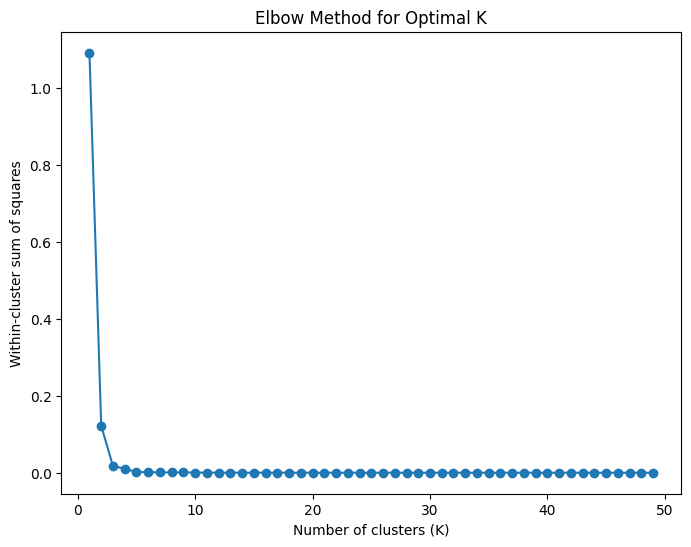

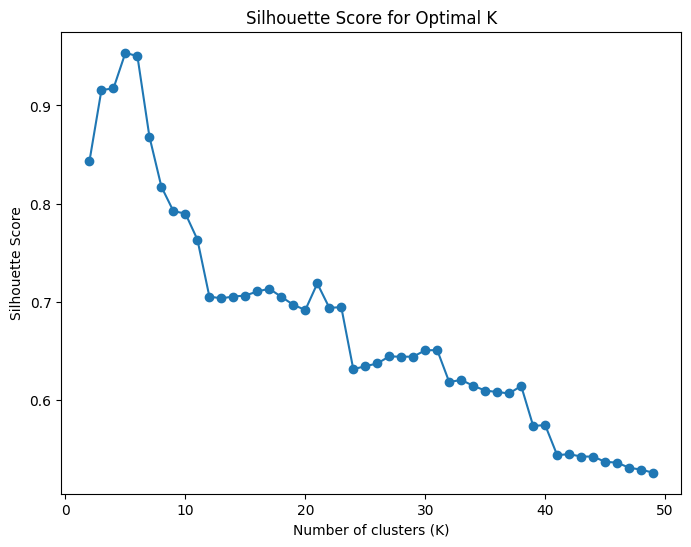

In [4]:
#K-means
#Get all dump positions for a given day
trip_day_before = dataloader.TripsLoader('03-10-2022')
all_dump_positions_for_day_before = []

for machine_number in trip_day_before._machines.keys():
    temp_machine = trip_day_before._machines[machine_number]
    if temp_machine.machine_type == 'Truck':
        all_dump_positions_for_day_before.append([trip.dump_latlon for trip in temp_machine.trips])

all_dump_positions_for_day_before =  [item for sublist in all_dump_positions_for_day_before for item in sublist]

# Assuming 'coordinates' is list of tuples [(lat1, lon1), (lat2, lon2), ...]
coordinates_array = np.array(all_dump_positions_for_day_before)

inertia = []
K_range = range(1, 50)  # You can adjust the range as needed

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(coordinates_array)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow Method for Optimal K')
plt.show()

silhouette_scores = []

for k in K_range:
    if k==1:
        silhouette_scores.append(None)
    
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(coordinates_array)
        labels = kmeans.labels_
        silhouette_scores.append(silhouette_score(coordinates_array, labels))

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

In [5]:
# Set the optimal K value you found from the elbow method and silhouette score analysis
optimal_K = 30

# Fit the KMeans model with the optimal K value
kmeans = KMeans(n_clusters=optimal_K, random_state=42, n_init='auto')
kmeans.fit(coordinates_array)

# Get the coordinates of the cluster centers for the optimal K value
cluster_centers = kmeans.cluster_centers_

In [6]:
# Create a map centered at the mean of all coordinates, with heatmap
map_center = np.mean(coordinates_array, axis=0)
m = L.Map(center=(map_center[0], map_center[1]), zoom=10)

# Add markers for each cluster center to the map
for center in cluster_centers:
    marker = L.Marker(location=(center[0], center[1]))
    m.add_layer(marker)
heatmap = L.Heatmap(locations=all_dump_positions_for_day_before,radius=20)
m.add_layer(heatmap)

# Display the map
m

Map(center=[59.960285839724534, 10.36365155826993], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [7]:
#Machine we want to look at
pred_dict_error = {}
for machine_nb in tqdm(trip._machines.keys()):
    some_machine = trip._machines[machine_nb]
    if some_machine.machine_type == 'Truck':
        for trips in some_machine.trips:    
            
            trip_speeds = []
            trip_dists = []
            time_keeper = []
            time_of_dump = trips.positions[0].timestamp # Just give it some value
            predicted_dump_latlon = None
            temp_predicted_dump_latlon = None
            predicted_dump_time = trips.positions[0].timestamp
            temp_predicted_dump_time = trips.positions[0].timestamp #Just need some value
            entering_working_area = []
            exiting_working_area = []
            initial_lat_lon = (trips.positions[0].lat, trips.positions[0].lon)
            in_working_area = False
            predicted_dump = False
            nb_of_positions_for_vector = 30 # 1 meaning the current versus the last, 5 meaning the current versus the fith last to be recorded
            list_of_inner_prods = []

            for coord in cluster_centers:
                if geopy.distance.geodesic(coord, initial_lat_lon).m < 100:
                    in_working_area = True

            actual_dump_lat_lon = trips.dump_latlon
            
            lowest_inner_prod = 1
            
            for i in range(len(trips.positions[1:])):
                current_time = trips.positions[i].timestamp
                prev_time = trips.positions[i-1].timestamp

                current_lat_lon = (trips.positions[i].lat,trips.positions[i].lon)

                if current_lat_lon == actual_dump_lat_lon:
                    time_of_dump = current_time

                prev_lat_lon = (trips.positions[i-1].lat,trips.positions[i-1].lon)
                
                

                seconds_gone = (current_time.to_pydatetime()-prev_time.to_pydatetime()).total_seconds()
                meters_driven = geopy.distance.geodesic(prev_lat_lon, current_lat_lon).m

                
                if seconds_gone > 0:
                    speed_kmh = (meters_driven/seconds_gone)*3.6
                    trip_speeds.append(speed_kmh)
                    trip_dists.append(meters_driven/1000)
                    time_keeper.append(current_time)

                    if i > 1+nb_of_positions_for_vector: #Create vector for computing reverse of vehicle
                        current_vector = [trips.positions[i].lat-trips.positions[i-nb_of_positions_for_vector].lat,trips.positions[i].lon-trips.positions[i-nb_of_positions_for_vector].lon]
                        prev_vector = [trips.positions[i-1].lat-trips.positions[i-1-nb_of_positions_for_vector].lat,trips.positions[i-1].lon-trips.positions[i-1-nb_of_positions_for_vector].lon]

                        current_vector_norm = current_vector/np.linalg.norm(current_vector)
                        prev_vector_norm = prev_vector/np.linalg.norm(prev_vector)
                        inner_product = np.inner(current_vector_norm,prev_vector_norm)
                        list_of_inner_prods.append(inner_product)
                    else:
                        list_of_inner_prods.append(0)

                    currently_in_working_area = False
                    for coord in cluster_centers:
                        if geopy.distance.geodesic(coord, current_lat_lon).m < 100:
                            currently_in_working_area = True
                        
                        
                    if not in_working_area and currently_in_working_area:
                        entering_working_area.append(current_time)
                        in_working_area = True
                    elif in_working_area and not currently_in_working_area:
                        exiting_working_area.append(current_time)
                        in_working_area = False
                    
                    #Demands to predict dump point
                    if in_working_area and speed_kmh < 5 and sum(trip_dists)>0.2:# and not predicted_dump: #want to add cumsum last 2 ish minutes to be lower than 500m for example
                        last_min_start = current_time-timedelta(minutes=1)
                        index_start_minute = None
                        for i, ts in enumerate(time_keeper):
                            if ts >= last_min_start:
                                index_start_minute = i
                                break
                        sum_over_last_minute = np.sum(trip_speeds[index_start_minute:])
                        
                        if sum_over_last_minute < 500 and list_of_inner_prods[-1] < lowest_inner_prod:
                            lowest_inner_prod = list_of_inner_prods[-1]
                            temp_predicted_dump_latlon = current_lat_lon
                            temp_predicted_dump_time = current_time
                            predicted_dump = True
            if predicted_dump:
                predicted_dump_time = temp_predicted_dump_time
                predicted_dump_latlon = temp_predicted_dump_latlon
                pred_dict_error[trips.trip_id] = {"seconds_passed": (trips.positions[-1].timestamp-trips.positions[0].timestamp).total_seconds(),
                                                "second_error": np.abs((time_of_dump-temp_predicted_dump_time).total_seconds()),
                                                "meter_driven": trips.length*1000,
                                                "meter_error": geopy.distance.geodesic(temp_predicted_dump_latlon, actual_dump_lat_lon).m}
                            
            
            """ # Plots, not wanted when a lot of data
            # Create subplots with 2 rows and 1 column
            fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.1)

            # Add the first line plot to the first subplot
            fig.add_trace(go.Scatter(x=time_keeper, y=trip_speeds, mode='lines', name='Speed'), row=1, col=1)
            fig.add_trace(go.Scatter(x=[time_of_dump], y=[0], mode='markers', marker=dict(symbol='cross', size=10, color='red'), name='Dump actual'), row=1, col=1)
            fig.add_trace(go.Scatter(x=[predicted_dump_time], y=[0], mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Dump predicted'), row=1, col=1)
            fig.add_trace(go.Scatter(x=entering_working_area, y=[0 for e in entering_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='green'), name='Entering working area'), row=1, col=1)
            fig.add_trace(go.Scatter(x=exiting_working_area, y=[0 for e in exiting_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='yellow'), name='Exiting working area'), row=1, col=1)

            # Add the second line plot to the second subplot
            fig.add_trace(go.Scatter(x=time_keeper, y=np.cumsum(trip_dists), mode='lines', name='Cumulative distance'), row=2, col=1)
            fig.add_trace(go.Scatter(x=[time_of_dump], y=[0], mode='markers', marker=dict(symbol='cross', size=10, color='red'), name='Dump actual'), row=2, col=1)
            fig.add_trace(go.Scatter(x=[predicted_dump_time], y=[0], mode='markers', marker=dict(symbol='star', size=10, color='red'), name='Dump predicted'), row=2, col=1)
            fig.add_trace(go.Scatter(x=entering_working_area, y=[0 for e in entering_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='green'), name='Entering working area'), row=2, col=1)
            fig.add_trace(go.Scatter(x=exiting_working_area, y=[0 for e in exiting_working_area], mode='markers', marker=dict(symbol='cross', size=10, color='yellow'), name='Exiting working area'), row=2, col=1)

            # Add the second line plot to the second subplot
            fig.add_trace(go.Scatter(x=time_keeper, y=list_of_inner_prods, mode='lines', name='Inner product of vectors'), row=3, col=1)


            # Update layout settings for both subplots
            fig.update_layout(title=str('Subplots of Speeds and cumulative distance, trip ID: '+ trips.trip_id),
                            xaxis_title='Timestamp',
                            showlegend=True)

            # Show the plot
            fig.show()
            try:
                m = L.Map(layout=Layout(width='60%', height='700px'), center=[59.95, 10.3])
                line = L.Polyline(locations=[(pos.lat, pos.lon) for pos in trips.positions], color="blue" ,fill=False)
                start_point = L.CircleMarker(location=(trips.positions[0].lat,trips.positions[0].lon), color="green")
                end_point = L.CircleMarker(location=(trips.positions[-1].lat,trips.positions[-1].lon), color="orange")
                actual_dump_point = L.CircleMarker(location=actual_dump_lat_lon, color="red")
                predicted_dump_point = L.Marker(location=predicted_dump_latlon, draggable=False)
                m.add_layer(line)
                m.add_layer(start_point)
                m.add_layer(end_point)
                m.add_layer(actual_dump_point)
                m.add_layer(predicted_dump_point)
                display(m)
            except:
                pass """

100%|██████████| 23/23 [11:52<00:00, 30.99s/it]


In [15]:
#Want to define some metrics, such as how many meter we miss by average and how much time we miss by average
pred_dict_error

{'622ae5dbeb2cc6000037c359': {'seconds_passed': 1494.994,
  'second_error': 35.999,
  'meter_driven': 11303.402728975536,
  'meter_error': 4.949258399995693},
 '622aebb5c5acbc00006e7cbe': {'seconds_passed': 1706.999,
  'second_error': 1.0,
  'meter_driven': 11442.27221819106,
  'meter_error': 0.8616762768175831},
 '622af2676eaee30000b21c1a': {'seconds_passed': 2920.001,
  'second_error': 59.998,
  'meter_driven': 12125.942249729407,
  'meter_error': 2.192907403505312},
 '622afdd2deeab800004c3acc': {'seconds_passed': 1421.01,
  'second_error': 33.999,
  'meter_driven': 11119.106988653375,
  'meter_error': 10.839217700578512},
 '622b0366a28a13000045df78': {'seconds_passed': 1720.0,
  'second_error': 22.0,
  'meter_driven': 11286.631176583289,
  'meter_error': 5.302072425395645},
 '622b0a3420382500004d3dbc': {'seconds_passed': 1515.994,
  'second_error': 66.999,
  'meter_driven': 11215.31596841044,
  'meter_error': 17.56746460489564},
 '622b103caf03e20000350283': {'seconds_passed': 1446.0

In [16]:
df = pd.DataFrame(pred_dict_error).T

In [17]:
df["second_error"]

622ae5dbeb2cc6000037c359      35.999
622aebb5c5acbc00006e7cbe       1.000
622af2676eaee30000b21c1a      59.998
622afdd2deeab800004c3acc      33.999
622b0366a28a13000045df78      22.000
                              ...   
622b94bb7fe40d0000f7d3fd    3234.002
622ba72d509d56000096416a       7.001
622ba87c4387df0000d619e1      35.000
622baa02ea4c4e00007967cb      85.000
622babc2df2b0e0000589155     729.003
Name: second_error, Length: 514, dtype: float64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 514 entries, 622ae5dbeb2cc6000037c359 to 622babc2df2b0e0000589155
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   seconds_passed  514 non-null    float64
 1   second_error    514 non-null    float64
 2   meter_driven    514 non-null    float64
 3   meter_error     514 non-null    float64
dtypes: float64(4)
memory usage: 36.2+ KB


In [12]:
df

,seconds_passed,second_error,meter_driven,meter_error
622ae5dbeb2cc6000037c359,1494.994,35.999,11303.402729,4.949258
622aebb5c5acbc00006e7cbe,1706.999,1.000,11442.272218,0.861676
622af2676eaee30000b21c1a,2920.001,59.998,12125.942250,2.192907
622afdd2deeab800004c3acc,1421.010,33.999,11119.106989,10.839218
622b0366a28a13000045df78,1720.000,22.000,11286.631177,5.302072
...,...,...,...,...
622b94bb7fe40d0000f7d3fd,4578.997,3234.002,18883.825754,6775.277104
622ba72d509d56000096416a,366.003,7.001,411.845171,21.866483
622ba87c4387df0000d619e1,318.000,35.000,413.658865,10.764398
622baa02ea4c4e00007967cb,404.999,85.000,490.053624,25.565612


In [13]:
df["seconds_percentage_error"] = (df["second_error"]/df["seconds_passed"])*100
df["meters_percentage_error"] = (df["meter_error"]/df["meter_driven"])*100

array([[<Axes: title={'center': 'seconds_passed'}>,
        <Axes: title={'center': 'second_error'}>],
       [<Axes: title={'center': 'meter_driven'}>,
        <Axes: title={'center': 'meter_error'}>],
       [<Axes: title={'center': 'seconds_percentage_error'}>,
        <Axes: title={'center': 'meters_percentage_error'}>]],
      dtype=object)

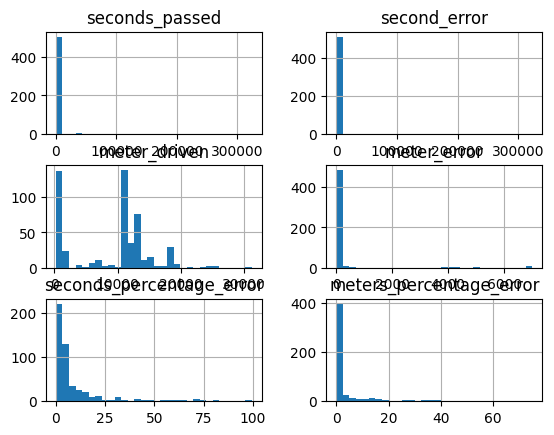

In [14]:
df.hist(bins=30)

In [ ]:
import plotly.express as px
fig = px.ecdf(df, x="seconds_percentage_error")
fig.show()

In [ ]:
fig = px.ecdf(df, x="meters_percentage_error")
fig.show()